In [1]:
# 
# Copyright (c) 2022 Go2Market Insights d/b/a Analyzr
# All rights reserved
# https://analyzr.ai
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions
# of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO
# THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
# TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
# 
# For Python SDK reference go to https://https://analyzr-sdk-python.readthedocs.io/
# For support go to https://support.analyzr.ai
# 
# To run this notebook you will need the following Python packages:
#   - pandas
#   - numpy
#   - analyzrclient
#   - matplotlib
#   - seaborn
#
import pandas as pd
import numpy as np
import sys, os, uuid
from copy import deepcopy
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

In [2]:
# 
# LOAD DATA
# 
raw_data = pd.read_csv('https://g2mstaticfiles.blob.core.windows.net/$web/titanic.csv', encoding = "ISO-8859-1", low_memory=False)
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 
# TAKE A SUBSET OF THE ORIGINAL DATASET
# 
# This step selects a subset of the original dataset for training purposes. 
# It also assigns a record identifier field (ID_FIELD) for audit and reconciliation 
# purposes. 
# 
SELECTED_FIELDS = [
    'Survived',
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'PassengerId',
]
ID_FIELD = 'PassengerId'
df = raw_data[SELECTED_FIELDS].dropna()
df[ID_FIELD] = df[ID_FIELD].astype('string')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,PassengerId
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,3
3,1,1,female,35.0,1,0,53.1000,S,4
4,0,3,male,35.0,0,0,8.0500,S,5


In [4]:
# 
# ASSIGN VARIABLE TYPES
# 
# This step assigns variable types. OUTCOME_VAR identifies the dependent variable.
# Other arays identify independent variabkes by type: categorical, numerical, or boolean. 
# 
OUTCOME_VAR = 'Survived' 
CATEGORICAL_VARS = ['Sex', 'Embarked'] 
NUMERICAL_VARS = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] 
BOOLEAN_VARS = [OUTCOME_VAR] 

In [5]:
# 
# START ANALYZR CLIENT
# 
# Access to the Analyzr API requires credentials. Contact your account manager or contact 
# our support team at https://support.analyzr.ai for more info. If you are a free tier user 
# you can skip this step altogether and use your local compute resources. 
# 
# For installation instructions on the Analyzr client see https://github.com/analyzr-ai/analyzr-sdk-python
# 
from analyzrclient import Analyzer
analyzer = Analyzer(host='analyzr3.api.g2m.ai')
analyzer.login()
analyzer.version()

Login successful


{'status': 200,
 'response': {'version': 'v1.6.11',
  'tenant': 'Analyzr3',
  'copyright': '2023 (c) Go2Market Insights, Inc. All rights reserved.'}}

In [6]:
#
# TRAIN MODEL
#
# This step performs model training and cross-validation. If you do not have API access, e.g. free 
# tier users, you will need to replace the training command with your own model.fit() statement 
# for model training and cross-validation using local compute resources.  
# 
# Note also this version keeps polling the API while the model is training. For longer training runs 
# you may want to disable polling and manually check the status of your model (see next cell). 
# 
t_0 = datetime.datetime.now()
client_id = 'test'
# algorithm = 'logistic-regression-classifier'
algorithm = 'xgboost-classifier'
verbose = True
res = analyzer.propensity.train(
    df, client_id=client_id, 
    idx_var=ID_FIELD, outcome_var=OUTCOME_VAR, categorical_vars=CATEGORICAL_VARS, numerical_vars=NUMERICAL_VARS, 
    algorithm=algorithm, train_size=0.5, smote=True, 
    buffer_batch_size=1000, verbose=verbose, poll=True, compressed=True, encoding=True
)
print('model_id: {}'.format(res['model_id']))
print('total time: {}'.format(datetime.datetime.now()-t_0))

Model ID: 225b7f54-58d5-4588-964f-024896538b6b
Encoding categorical variables:
	Sex
	Embarked
Encoding numerical variables:
	Pclass
	Age
	SibSp
	Parch
	Fare
Encoding record IDs...
Encoding field names...
Saving encoding keys locally...
Saving data to buffer...
        Processed batch 1 of 1
Training propensity model using data in buffer...
Training request posted.
[_poll][82] {'status': 200, 'response': {'request_id': '225b7f54-58d5-4588-964f-024896538b6b', 'status': 'Complete', 'details': 'Post-processing results in analytics engine...'}}
Retrieving training results...
    Retrieving features...
    Retrieving confusion matrix...
    Retrieving performance stats...
    Retrieving ROC curve...
Clearing buffer...
model_id: 225b7f54-58d5-4588-964f-024896538b6b
total time: 0:01:56.521745


In [7]:
#
# CHECK STATUS OF MODEL RUN
# 
# For manual polling uncomment the lines below. 
# 
# res = analyzer.propensity.check_status(model_id=res['model_id'], client_id=client_id, verbose=True) 
# res 

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

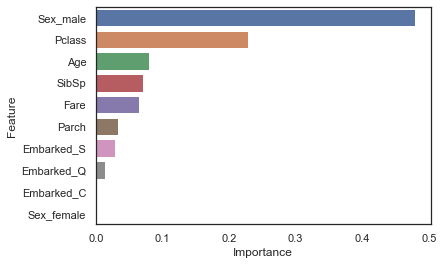

In [8]:
#
# DISPLAY FEATURE IMPORTANCE 
#
sns.barplot(data=res['features'][0:15], x='Importance', y='Feature')

In [9]:
#
# SHOW FEATURE IMPORTANCE TABLE
#
res['features']

,Feature,Importance
0,Sex_male,0.478625
1,Pclass,0.229117
2,Age,0.079784
3,SibSp,0.071440
4,Fare,0.065022
5,Parch,0.033172
6,Embarked_S,0.028625
7,Embarked_Q,0.014216
8,Embarked_C,0.000000
9,Sex_female,0.000000


In [10]:
#
# SHOW CONFUSION MATRIX
#
res['confusion_matrix']

,0,1
0,176,37
1,34,109


In [11]:
#
# SHOW ERROR STATISTICS
#
res['stats']

,Parameter,Value
0,Accuracy,0.800562
1,Precision,0.746575
2,Recall,0.762238
3,Occurrence,0.401685
4,F1,0.754325
5,Gini,0.732362
6,AUC,0.866181


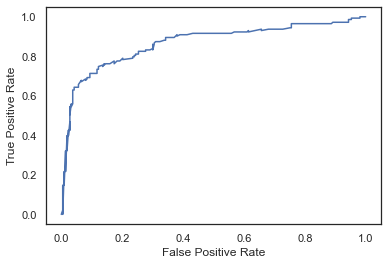

In [12]:
#
# PLOT RECEIVER OPERATING CHARACTERISTIC CURVE
#
plt.plot(res['roc']['FPR'], res['roc']['TPR'], label=algorithm) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()